# Anchor pass-QC snATAC-seq object to scRNA-seq (GFP+ only)
- https://satijalab.org/seurat/articles/seurat5_atacseq_integration_vignette

## Set up correct conda environment

In [1]:
.libPaths()

[1] "/home/users/xjluo/miniconda3/envs/jupyter_env/lib/R/library"

In [2]:
.libPaths('/home/groups/tttt/xjluo/miniconda3/envs/single_cell_Seurat_v5/lib/R/library')
.libPaths()

[1] "/home/groups/tttt/xjluo/miniconda3/envs/single_cell_Seurat_v5/lib/R/library"
[2] "/home/users/xjluo/miniconda3/envs/jupyter_env/lib/R/library"

In [3]:
library(tidyverse)
library(viridis)
library(Seurat)
library(Signac)
library(Azimuth)
library(EnsDb.Mmusculus.v79)
library(BSgenome.Mmusculus.UCSC.mm10)
library(ggpointdensity)
library(ggExtra)

set.seed(1234)
options(repr.matrix.max.cols=100, repr.matrix.max.rows=50)
options(warn=-1)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



Attaching shinyBS

Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following ob

In [4]:
sample <- 'E1'

In [5]:
# value is either 'ALL' or 'GFP' depending on the script
all_or_gfp <- 'GFP'

## STEP 0: Paths

In [6]:
data_master_dir <- '/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC'

data_master_dir

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC"

In [7]:
data_master_dir_old <- '/oak/stanford/groups/tttt/collaboration/jin/240613_ATAC'
rna_path <- paste0(data_master_dir_old, '/', 'RNA', '/', 'ctx.Robj')

rna_path

[1] "/oak/stanford/groups/tttt/collaboration/jin/240613_ATAC/RNA/ctx.Robj"

In [8]:
atac_dir <- '/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step1_qc/ATAC'
atac_path <- paste0(atac_dir, '/2_filtered_objects/', sample, ".ATAC.filtered.Seurat.v5.rds")

atac_path

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step1_qc/ATAC/2_filtered_objects/E1.ATAC.filtered.Seurat.v5.rds"

In [9]:
# save anchored ATAC objects here
save_dir <- paste0(atac_dir, '/3_filtered_anchored_to_', all_or_gfp, '_RNA')

save_dir

# Ensure the directory exists
if (!dir.exists(save_dir)) {
  dir.create(save_dir, recursive=TRUE)
}

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step1_qc/ATAC/3_filtered_anchored_to_GFP_RNA"

## STEP 1: Load data

### STEP 1.1 Load RNA object for appropriate condition
- Condition 1: all cells, OR
- Condition 2 : GFP+ sorted only

In [10]:
load(rna_path)

# NOTE: the 'v4' in variable names is just for convenience, since this notebook is adapted from a previous ATAC dataset.
# Seurat v5 is now used.

rna.obj.annotated.Seurat.v4 <- ctx

In [11]:
rna.obj.annotated.Seurat.v4

An object of class Seurat 
32475 features across 7158 samples within 6 assays 
Active assay: RNA (32285 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 5 other assays present: ADT, prediction.score.class, prediction.score.cluster, prediction.score.subclass, prediction.score.cross_species_cluster
 5 dimensional reductions calculated: integrated_dr, ref.umap, pca, umap.unintegrated, umap

In [12]:
table(rna.obj.annotated.Seurat.v4$orig.ident)


 all GFP2 
3045 4113 

In [13]:
Idents(rna.obj.annotated.Seurat.v4) <- 'orig.ident'

# Uncomment below line if this notebook focuses on the GFP+ only scRNA-seq experiment

# Now called "GFP2" as of July 22, 2024. Previous RNA object used "GFP"
rna.obj.annotated.Seurat.v4 <- subset(x = rna.obj.annotated.Seurat.v4, idents = c('GFP2'))

In [14]:
rna.obj.annotated.Seurat.v4

An object of class Seurat 
32475 features across 4113 samples within 6 assays 
Active assay: RNA (32285 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 5 other assays present: ADT, prediction.score.class, prediction.score.cluster, prediction.score.subclass, prediction.score.cross_species_cluster
 5 dimensional reductions calculated: integrated_dr, ref.umap, pca, umap.unintegrated, umap

### STEP 1.2: Load ATAC object (all GFP-sorted)

In [15]:
atac.obj.annotated.Seurat.v4 <- readRDS(atac_path)

In [16]:
atac.obj.annotated.Seurat.v4

An object of class Seurat 
299905 features across 2663 samples within 1 assay 
Active assay: ATAC (299905 features, 299905 variable features)
 2 layers present: counts, data
 2 dimensional reductions calculated: lsi, umap

### STEP 1.3: Inspect objects

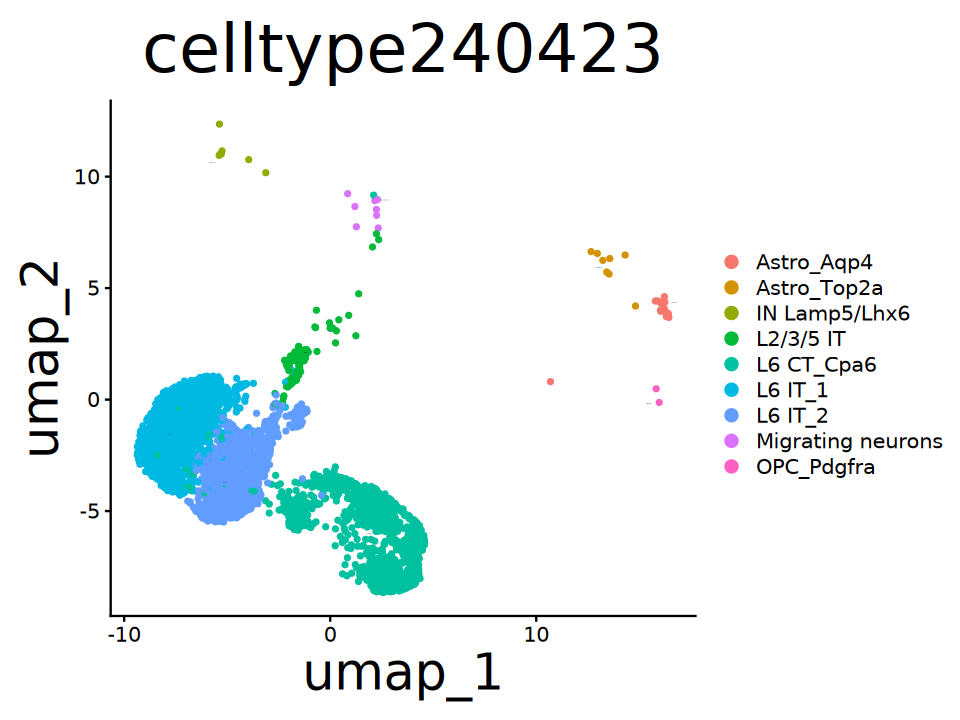

In [17]:
# RNA
options(repr.plot.width=8, repr.plot.height=6)

DimPlot(rna.obj.annotated.Seurat.v4, shuffle=TRUE, label = TRUE, repel = TRUE, pt.size=1, label.size=0, reduction = "umap", group.by = 'celltype240423', raster=FALSE) + theme(plot.title = element_text(size=40),
                                                                                                                                         axis.title = element_text(size=30)
                                                                                                                                        )
     

     
     


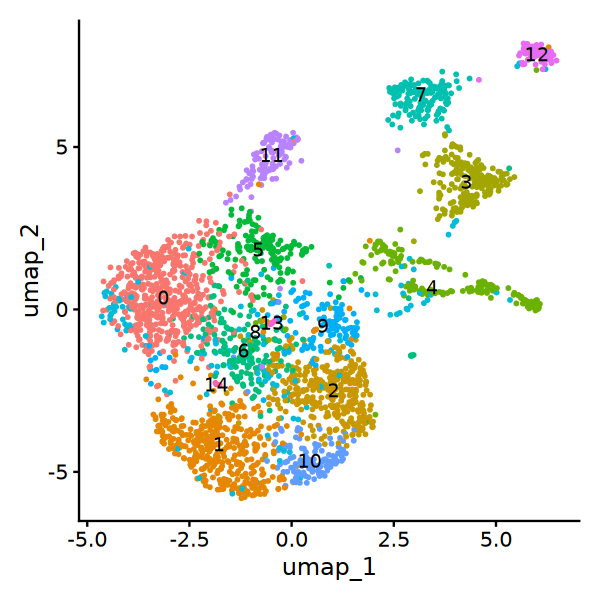

In [18]:
# ATAC
options(repr.plot.width=5, repr.plot.height=5)

DimPlot(object = atac.obj.annotated.Seurat.v4, label = TRUE) + NoLegend()

## STEP 2: Anchor ATAC to RNA

In [19]:
# quantify gene activity
DefaultAssay(atac.obj.annotated.Seurat.v4) <- 'ATAC'
gene.activities <- GeneActivity(atac.obj.annotated.Seurat.v4, features = VariableFeatures(rna.obj.annotated.Seurat.v4))

Extracting gene coordinates

Extracting reads overlapping genomic regions



In [20]:
# add gene activities as a new assay
atac.obj.annotated.Seurat.v4[["ACTIVITY"]] <- CreateAssayObject(counts = gene.activities)

# normalize gene activities
DefaultAssay(atac.obj.annotated.Seurat.v4) <- "ACTIVITY"
atac.obj.annotated.Seurat.v4 <- NormalizeData(atac.obj.annotated.Seurat.v4)
atac.obj.annotated.Seurat.v4 <- ScaleData(atac.obj.annotated.Seurat.v4, features = rownames(atac.obj.annotated.Seurat.v4))

Centering and scaling data matrix



In [21]:
# Identify anchors
transfer.anchors <- FindTransferAnchors(reference = rna.obj.annotated.Seurat.v4, 
                                        query = atac.obj.annotated.Seurat.v4, 
                                        features = VariableFeatures(object = rna.obj.annotated.Seurat.v4),
                                        reference.assay = "RNA", 
                                        query.assay = "ACTIVITY", 
                                        reduction = "cca")

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 10472 anchors



## STEP 3: Annotate snATAC-seq cells via label transfer

In [22]:
table(rna.obj.annotated.Seurat.v4$celltype240423)


       Astro_Aqp4       Astro_Top2a     IN Lamp5/Lhx6         L2/3/5 IT 
               19                 8                 7                89 
       L6 CT_Cpa6           L6 IT_1           L6 IT_2 Migrating neurons 
             1341              1440              1199                 8 
       OPC_Pdgfra 
                2 

In [23]:
celltype.predictions <- TransferData(anchorset = transfer.anchors, 
                                     refdata = rna.obj.annotated.Seurat.v4$celltype240423,
                                     weight.reduction = atac.obj.annotated.Seurat.v4[["lsi"]], 
                                     dims = 2:30)

atac.obj.annotated.Seurat.v4 <- AddMetaData(atac.obj.annotated.Seurat.v4, metadata = celltype.predictions)

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [24]:
Reductions(atac.obj.annotated.Seurat.v4)

[1] "lsi"  "umap"

In [25]:
colnames(atac.obj.annotated.Seurat.v4@meta.data)

[1] "orig.ident"                         "nCount_ATAC"                       
 [3] "nFeature_ATAC"                      "nucleosome_signal"                 
 [5] "nucleosome_percentile"              "TSS.enrichment"                    
 [7] "TSS.percentile"                     "ATAC_snn_res.1.2"                  
 [9] "seurat_clusters"                    "nCount_ACTIVITY"                   
[11] "nFeature_ACTIVITY"                  "predicted.id"                      
[13] "prediction.score.L6.IT_1"           "prediction.score.L6.CT_Cpa6"       
[15] "prediction.score.L6.IT_2"           "prediction.score.L2.3.5.IT"        
[17] "prediction.score.Astro_Aqp4"        "prediction.score.Migrating.neurons"
[19] "prediction.score.IN.Lamp5.Lhx6"     "prediction.score.OPC_Pdgfra"       
[21] "prediction.score.Astro_Top2a"       "prediction.score.max"

## STEP 4: Visualize anchoring result

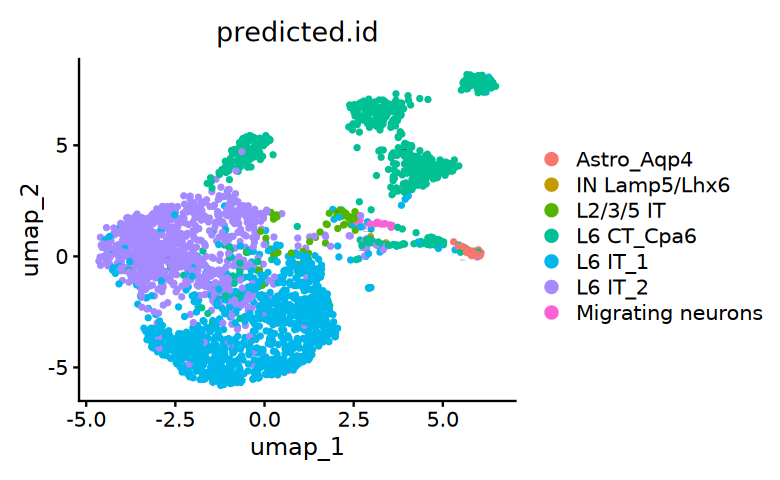

In [26]:
options(repr.plot.width=6.5, repr.plot.height=4)

DimPlot(atac.obj.annotated.Seurat.v4, 
        label = TRUE, 
        repel = TRUE, 
        pt.size=1, 
        label.size=0, 
        reduction = "umap", 
        group.by = 'predicted.id')


In [27]:
table(atac.obj.annotated.Seurat.v4$predicted.id)


       Astro_Aqp4     IN Lamp5/Lhx6         L2/3/5 IT        L6 CT_Cpa6 
               31                 4                55               645 
          L6 IT_1           L6 IT_2 Migrating neurons 
             1019               892                17 

## STEP 5: Save labeled snATAC-seq object 

In [28]:
save_dir

[1] "/oak/stanford/groups/tttt/collaboration/jin/240821_ATAC/xjluo_analysis/step1_qc/ATAC/3_filtered_anchored_to_GFP_RNA"

In [29]:
saveRDS_path <- paste0(save_dir, '/', sample, ".ATAC.anchored.", all_or_gfp, ".annotated.Seurat.v5.rds")
saveRDS(atac.obj.annotated.Seurat.v4, file = saveRDS_path)

atac.obj.annotated.Seurat.v4
Version(atac.obj.annotated.Seurat.v4)

print('Object saved')

An object of class Seurat 
301433 features across 2663 samples within 2 assays 
Active assay: ACTIVITY (1528 features, 0 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: ATAC
 2 dimensional reductions calculated: lsi, umap

[1] '5.0.2'

[1] "Object saved"


# END